In [1]:
import pandas as pd
import seaborn as sns
import pybedtools as pbt
import os
import Bio.SeqIO as seq
import numpy as np
import matplotlib.pyplot as plt

scriptpath = "../../src/"
sys.path.append(os.path.abspath(scriptpath))
from KmerGroups import get_coverage

In [2]:
# Regions included in the metaprofile
bedRegs = pbt.BedTool('../../results/Metaprofiles/PAS_Quantseq/AllRegionsInMetaprofile.bed.gz')
dfRegs = bedRegs.to_dataframe()
# Naive regions
dfNaive = pd.read_csv('../../results/Metaprofiles/PAS_Quantseq/NaiveGenesIncludedInTheMetaprofile_TMPGreaterThan5.csv', index_col=0)
regsNaive = pd.read_csv('../../results/Metaprofiles/PAS_Quantseq/AllNaiveRegions.bed.gz', sep='\t', header=None)
regsNaive = regsNaive.loc[regsNaive[3].isin(dfNaive.stable_gene_id.values.tolist())]
bedNaive = pbt.BedTool.from_dataframe(regsNaive)


# Genome
fasta = '../../data/genomes/Goodwright_m39/GRCm39.primary_assembly.genome.fa'

# K-mer groups
kmerGroups = pd.read_csv('../../results/20220906_ClusterKmers/FlatKmerClusters_Normalscale.tsv', sep='\t', index_col=0)

# Save to
outpath = '../../results/Metaprofiles/PAS_Quantseq/plots/'
os.makedirs(outpath, exist_ok=True)

# Get k-mer groups
uuuu = kmerGroups.loc[kmerGroups.consensus == 'UUUU'].index.tolist()
ugau = kmerGroups.loc[kmerGroups.consensus == 'UGAU'].index.tolist()
aggg = kmerGroups.loc[kmerGroups.consensus.isin(['AGGG', 'UGGG'])].index.tolist()
for el in [uuuu, ugau, aggg]:
    print(len(el))

55
14
24


In [9]:
bedRegs.head()

chr1	4843404	4843655	CONTROL	0	-	ENSMUSG00000033845
 chr1	4967906	4968157	DOWN	0	+	ENSMUSG00000033813
 chr1	9617456	9617707	DOWN	0	+	ENSMUSG00000061024
 chr1	10095023	10095274	CONTROL	0	-	ENSMUSG00000025917
 chr1	10206771	10207022	CONTROL	0	+	ENSMUSG00000056763
 chr1	12931194	12931445	DOWN	0	+	ENSMUSG00000016918
 chr1	13634973	13635224	CONTROL	0	-	ENSMUSG00000025935
 chr1	14823544	14823795	DOWN	0	-	ENSMUSG00000025930
 chr1	15914047	15914298	DOWN	0	+	ENSMUSG00000025925
 chr1	16713252	16713503	DOWN	0	-	ENSMUSG00000079658
 

In [3]:
def convertDictToList(d):
    return [d[i] for i in sorted([int(v) for v in d.keys()])]

def comp_coverage(l):
    return sum(l) * 100 / len(l)

In [4]:
dfRegs.groupby('name').count()['chrom']

name
CONTROL    1739
DOWN        831
UP          633
Name: chrom, dtype: int64

In [5]:
heatmaps = {}
for id, bt in dict(zip(['fullGroups', 'naive'],[bedRegs, bedNaive])).items():
    # Extract sequences
    bt.sequence(fi=fasta, s=True, name=True, fo=f'{outpath}/{id}_Sequences.fasta')
    # Parse sequences to df
    array = []
    with open(f'{outpath}/{id}_Sequences.fasta') as handle:
        for record in seq.parse(handle, "fasta"):
            array.append([record.id, str(record.seq).replace('T', 'U')])
    dfSequences = pd.DataFrame(array, columns=['id', 'sequence'])
    dfSequences['name'] = dfSequences.id.apply(lambda x: x.split('::')[0])

    # Get coverage for k-mer groups across the entire sequence
    dfSequences['UUUU'] = dfSequences.sequence.apply(lambda x: get_coverage(x, kmer_group=uuuu, kmer_length=5))
    dfSequences['GGGA-GGGU'] = dfSequences.sequence.apply(lambda x: get_coverage(x, kmer_group=aggg, kmer_length=5))
    dfSequences['UGAU'] = dfSequences.sequence.apply(lambda x: get_coverage(x, kmer_group=ugau, kmer_length=5))

    #Put coverages in list form
    dfSequences['UUUU'] = dfSequences['UUUU'].apply(lambda x: convertDictToList(x))
    dfSequences['GGGA-GGGU'] = dfSequences['GGGA-GGGU'].apply(lambda x: convertDictToList(x))
    dfSequences['UGAU'] = dfSequences['UGAU'].apply(lambda x: convertDictToList(x))

    # Split regions into differentially regulated groups
    if id == 'fullGroups':
        dfSequencesDown = dfSequences.loc[dfSequences.name == 'DOWN'].reset_index(drop=True)
        dfSequencesOther = dfSequences.loc[dfSequences.name != 'DOWN'].reset_index(drop=True)
        dfDict = {'DOWN': dfSequencesDown, 'CONTROL+UP': dfSequencesOther}
    else:
        dfDict = {'naive': dfSequences}

    # Organize into heatmap form
    cols = ['UUUU', 'GGGA-GGGU', 'UGAU']
    heatmapDict = {}
    for c in cols:
        dfheatmap = pd.DataFrame()
        for k, v in dfDict.items():
            array = np.array(v[c].values.tolist())
            if len(array) > 0:
                split_array = np.array_split(array, 25, axis=1)
                binCoverages = []
                for a in split_array:
                    coverage = np.apply_along_axis(comp_coverage, 1, a)
                    binCoverages.append(coverage.mean())
                dfheatmap[k] = binCoverages
        heatmapDict[c] = dfheatmap
    heatmaps[id] = heatmapDict

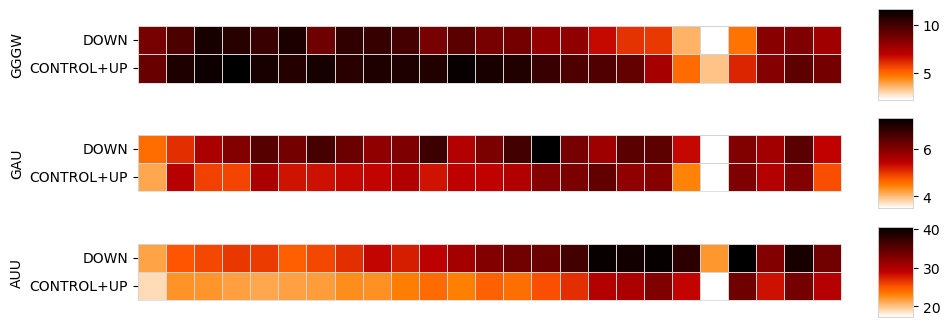

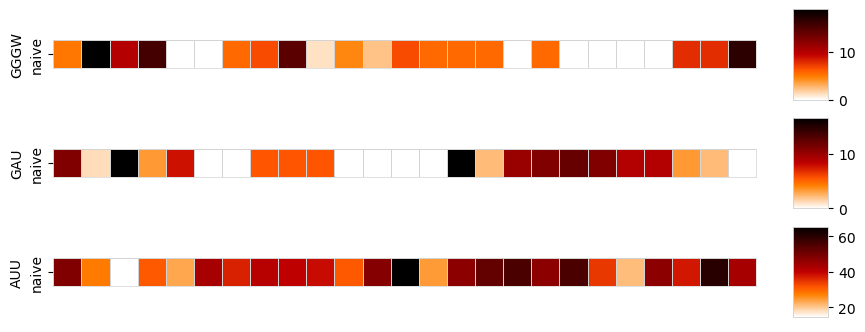

In [6]:
for id, heatmapDict in heatmaps.items():
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,4), gridspec_kw={'width_ratios':[10, 0.5], 'wspace':0.1})
    sns.heatmap(heatmapDict['GGGA-GGGU'].T, square=True, cmap='gist_heat_r', ax=axs[0, 0], xticklabels=False, cbar_ax=axs[0, 1], linewidths=.5, linecolor='lightgrey')
    axs[0, 0].set_ylabel('GGGW')
    sns.heatmap(heatmapDict['UGAU'].T, square=True, cmap='gist_heat_r', ax=axs[1, 0], xticklabels=False, cbar_ax=axs[1, 1], linewidths=.5, linecolor='lightgrey')
    axs[1, 0].set_ylabel('GAU')
    sns.heatmap(heatmapDict['UUUU'].T, square=True, cmap='gist_heat_r', ax=axs[2, 0], xticklabels=False, cbar_ax=axs[2, 1], linewidths=.5, linecolor='lightgrey')
    axs[2, 0].set_ylabel('AUU')

    for ax in axs.ravel():
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(.5)
            spine.set_color('lightgrey')

    if id == 'fullGroups':
        fig.savefig(f'{outpath}/geneGroups_motifCoverage_heatmap_cellLimits.pdf', bbox_inches='tight')
    else:
        for ax in axs.ravel()[::2]:
            ax.set_yticklabels(['naive'])
        fig.savefig(f'{outpath}/naiveGenes_motifCoverage_heatmap_cellLimits.pdf', bbox_inches='tight')